In [1]:
import pandas as pd

# sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.decomposition import PCA

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

In [2]:
data = pd.read_csv("Exam_Performance_Data.csv", sep=";")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [4]:
# checking for null values
print(data.info(verbose=True))  # to check for null entries

# no null entries where found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


In [5]:
# checking for duplicates, since no IDs where given in the dataset
duplicates = data.duplicated().sum()

print(duplicates)

# one duplicate has been found
data.drop_duplicates(inplace=True)  # duplicate will be dropped

1


In [6]:
# test scores will be summarized into a meta score, it might be interesting also to see which score is the most...
# ...impactful
data["Test_Meta_Score"] = data["math score"] + data["reading score"] + data["writing score"]

# test preparation will be converted into a simple binary (dummy) variable 0/1, since its impact can be assumed...
# ...quite clearly; lunch was not changed accordingly, since it is not as clear
data["test preparation course"] = data["test preparation course"].replace({"completed": 1, "none": 0})

# transforming education data for the one hot encoding

data['parental level of education'] = data['parental level of education'].replace({'some high school':'some_high_school','high school': 'high_school','some college':'some_college',"associate's degree":"associate's_degree","bachelor's degree":"bachelor's_degree","master's degree":"master's_degree"})

categorical_cols = ['gender', 'race/ethnicity', 'lunch']
ordinal_cols = ['parental level of education']
numerical_cols = ['test preparation course', 'math score', 'reading score', 'writing score', 'Test_Meta_Score']
# test preperation course is an already one hot encoded variable

In [7]:
# Create a transformer for each data type
# Transfomer for categorical data based on OHC
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
])

# Encoding of ordinal data
ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[['some_high_school','high_school','some_college',"associate's_degree","bachelor's_degree","master's_degree"]]))
])

# Powertransformer normalises data with the assumtption that data is normaly distributed
numerical_transformer = Pipeline(steps=[
    ("transformer", PowerTransformer())
])


In [8]:
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numerical_transformer, numerical_cols)
    ])


In [9]:
# Full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

pipeline.fit(data)
transformed_data = pipeline.transform(data)

# create a df from transformed data to have a better understanding of data
transformed_df = pd.DataFrame(transformed_data, columns = pipeline.fit(data).get_feature_names_out().tolist())
transformed_df

/Users/saarthakkataria/Documents/Code/intro-data-analytics/data_analytics_ws23/data_analytics_ws23-1/.data_analytics/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/saarthakkataria/Documents/Code/intro-data-analytics/data_analytics_ws23/data_analytics_ws23-1/.data_analytics/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,cat__gender_male,cat__race/ethnicity_group B,cat__race/ethnicity_group C,cat__race/ethnicity_group D,cat__race/ethnicity_group E,cat__lunch_standard,ord__parental level of education,num__test preparation course,num__math score,num__reading score,num__writing score,num__Test_Meta_Score
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.411034,0.018932,-0.165358,-0.325164,-0.167563
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.708700,-1.677187,-0.700882,-0.829146,-1.129495
2,1.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.708700,-0.500274,-0.634985,-1.137205,-0.800760
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.708700,0.684655,0.600212,-0.003784,0.441206
4,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.411034,0.752178,0.248229,-0.003784,0.346324
...,...,...,...,...,...,...,...,...,...,...,...,...
994,1.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.708700,0.416256,0.040205,-0.197177,0.087666
995,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.411034,1.229378,1.544336,1.598314,1.537040
996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.708700,-2.144087,-2.179455,-1.676688,-2.085020
997,0.0,0.0,1.0,0.0,0.0,1.0,2.0,-0.708700,0.416256,0.318105,0.919589,0.584334


In [10]:
# Outliers
detector = ECOD()
detector.fit(transformed_df)
outliers = detector.predict(transformed_df)
transformed_df['outliers'] = outliers

data_no_outliers = transformed_df[transformed_df['outliers']==0].drop(["outliers"], axis = 1)
data_with_outliers = transformed_df.copy().drop(["outliers"], axis = 1)

/Users/saarthakkataria/Documents/Code/intro-data-analytics/data_analytics_ws23/data_analytics_ws23-1/.data_analytics/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


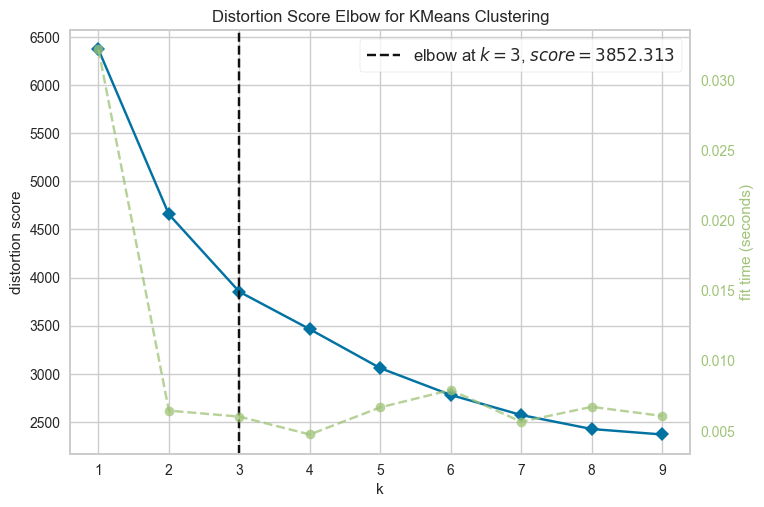

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(1, 10))

visualizer.fit(data_no_outliers)
visualizer.show()

In [30]:
km = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init = 10)
clusters = km.fit_predict(data_no_outliers)

print(km.cluster_centers_)

[[ 0.50526316  0.1754386   0.26666667  0.3122807   0.15438596  0.75789474
   1.05964912  0.18381975  0.38678031  0.40854936  0.37252187  0.40664836]
 [ 0.55913978  0.23655914  0.38172043  0.18817204  0.09139785  0.55376344
   3.59139785 -0.25284312 -0.41196098 -0.45786843 -0.42171317 -0.45437381]
 [ 0.5204918   0.25        0.37295082  0.22540984  0.0942623   0.53688525
   0.94262295 -0.30039048 -0.80263399 -0.80897931 -0.8332471  -0.85744071]
 [ 0.50543478  0.17934783  0.27717391  0.32608696  0.15217391  0.78804348
   3.36956522  0.22444395  0.88639119  0.90369644  0.93978665  0.95742998]]


In [31]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters)}")
print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers,clusters)}")



Silhouette Score: 0.18963735702605383
Davies bouldin score: 1.4902135482537529


PCA to reduce dimensions and visualise clusters differentiation

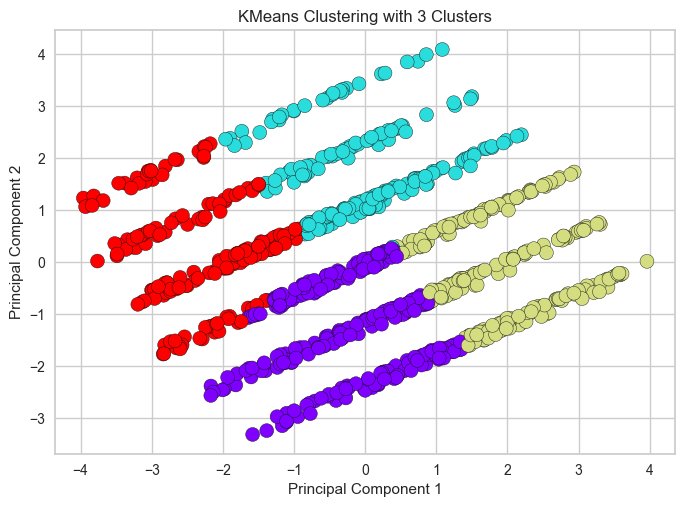

In [32]:
#data_no_outliers['cluster'] = clusters

## PCA to reduce dimensions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_no_outliers)

# Plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='rainbow', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with 3 Clusters')
plt.show()


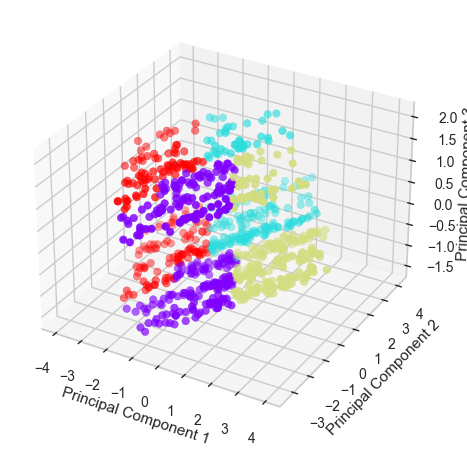

In [33]:
## PCA to reduce dimensions and visualise clusters differentiation

# Reduce data to 3D
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_no_outliers)

# 3D-Plot
graph = plt.figure()
axis = graph.add_subplot(projection="3d")
xdata = data_pca[:, 0]
ydata = data_pca[:, 1]
zdata = data_pca[:, 2]
axis.scatter3D(xdata, ydata, zdata, c=clusters, cmap = "rainbow", s=30)
axis.set_xlabel("Principal Component 1")
axis.set_ylabel("Principal Component 2")
axis.set_zlabel("Principal Component 3")
plt.show()

In [35]:
transformed_df["mean"] = transformed_df.mean(axis=1)

mean_vector = []

for x in transformed_df["mean"]:
    mean_vector.append(x)

sample_mean = transformed_df["mean"].mean()

variance_placeholder = []

for x in mean_vector:
    y = (x-sample_mean)**2
    variance_placeholder.append(y)

n_1 = len(variance_placeholder)-1

var_sum = sum(variance_placeholder)

sample_variance = var_sum/n_1

print (sample_variance)

0.1460395550229452


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


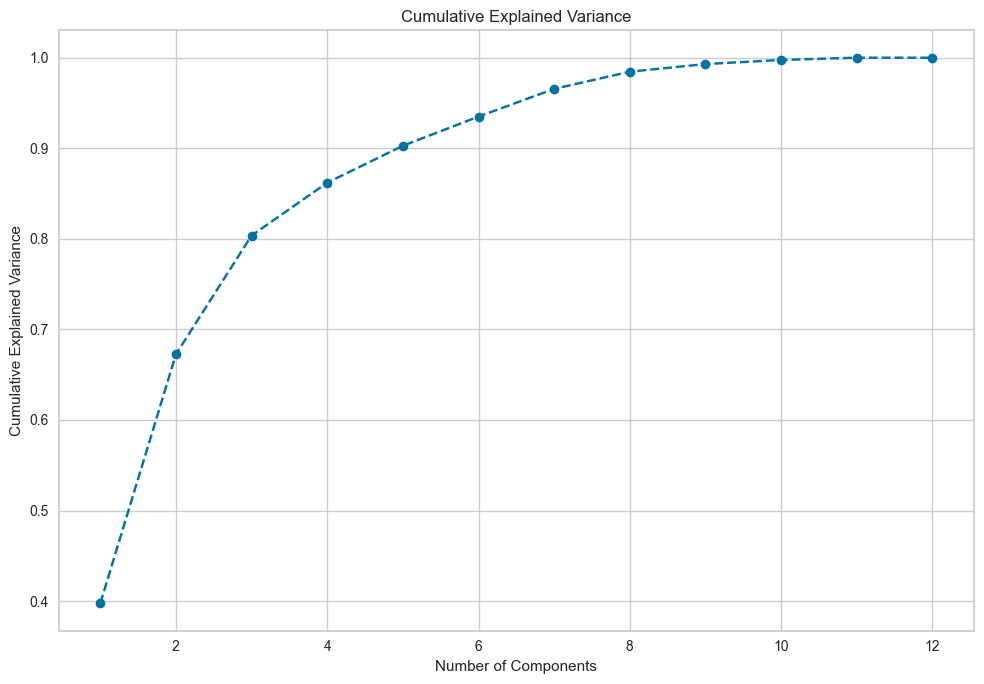

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming your data is in a variable called `data`
pca = PCA().fit(data_no_outliers)

# Calculate cumulative sum of explained variances
cum_sum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [37]:
# creating summary of a cluster

data['outliers'] = outliers
data = data[data['outliers']==0]
data['clusters'] = clusters

In [38]:
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Test_Meta_Score,outliers,clusters
0,male,group A,high_school,standard,1,67,67,63,197,0,0
1,female,group D,some_high_school,free/reduced,0,40,59,55,154,0,2
2,male,group E,some_college,free/reduced,0,59,60,50,169,0,2
3,male,group B,high_school,standard,0,77,78,68,223,0,0
4,male,group E,associate's_degree,standard,1,78,73,68,219,0,3
...,...,...,...,...,...,...,...,...,...,...,...
994,male,group E,high_school,free/reduced,1,86,82,75,243,0,0
995,male,group C,high_school,standard,0,73,70,65,208,0,0
996,male,group D,associate's_degree,free/reduced,1,85,91,92,268,0,3
998,female,group C,some_college,standard,0,73,74,82,229,0,0


In [39]:
import pandas as pd

def custom_mode(x):
    # If the data is categorical, compute the mode
    if x.dtype == 'object':
        return x.mode().iloc[0]
    # If the data is numeric, compute the median
    else:
        return x.median()

agg_dict = {
    'gender': custom_mode,
    'race/ethnicity': custom_mode,
    'parental level of education': custom_mode,
    'lunch': custom_mode,
    'test preparation course': custom_mode,
    'math score': custom_mode,
    'reading score': custom_mode,
    'writing score': custom_mode,
    'Test_Meta_Score': custom_mode,
}

result = data.groupby('clusters').agg(agg_dict)

In [40]:
result

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Test_Meta_Score
clusters,,,,,,,,,
0,male,group D,high_school,standard,0.0,72.0,75.0,73.0,220.0
1,male,group C,associate's_degree,standard,0.0,61.0,63.0,62.5,187.0
2,male,group C,some_high_school,standard,0.0,54.0,58.0,55.0,169.0
3,male,group D,associate's_degree,standard,0.0,80.0,83.0,83.0,244.5
